In [1]:
%load_ext autoreload
%autoreload 2

import sklearn.metrics as metrics
from utils.temperature_scaling import ModelWithTemperature
from matplotlib import pyplot as plt
import utils.visualisations
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms

import utils.metrics
import utils.model

import models.resnet_dropout
import models.resnet
import models.unet_model

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]

VOC_DICT = {cls:i for i,cls in enumerate(VOC_CLASSES)}

class VOCTransform(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, label):
        annotation = label["annotation"]
        id = int(annotation["filename"].replace(".jpg","").replace("_",""))
        out = {
            "boxes": [],
            "labels": [],
            "image_id": torch.tensor(id, dtype=torch.int64),
            "area":[],
            "iscrowd": []
        }
        for obj in annotation["object"]:
            box_dict = obj["bndbox"] 
            box = [float(box_dict["xmin"]),float(box_dict["ymin"]), float(box_dict["xmax"]), float(box_dict["ymax"])]
            out["boxes"].append(box)
            out["labels"].append(VOC_DICT[obj["name"]])
            out["area"].append((box[2]-box[0]) * (box[3] - box[1]))
            out["iscrowd"].append(0)
        out["boxes"] = torch.as_tensor(out["boxes"], dtype=torch.float)
        out["labels"] = torch.as_tensor(out["labels"], dtype=torch.int64)
        out["area"] = torch.as_tensor(out["area"], dtype=torch.float)
        out["iscrowd"] = torch.as_tensor(out["iscrowd"], dtype=torch.uint8)
        return out

            
def collate_fn(batch):
    return list(zip(*batch))


transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip()
])


target_transforms = torchvision.transforms.Compose([
    VOCTransform()
])


data_train = torchvision.datasets.VOCDetection(
    root="VOC", download=True, image_set="train", transform=transforms_train, target_transform=VOCTransform())
data_loader_train = torch.utils.data.DataLoader(data_train,
                                          batch_size=16,
                                          shuffle=True,
                                          collate_fn=collate_fn)



data_test = torchvision.datasets.VOCSegmentation(
    root="VOC", download=True, image_set="val", transform=torchvision.transforms.ToTensor(), target_transform=target_transforms)
data_loader_test = torch.utils.data.DataLoader(data_test,
                                          batch_size=16,
                                          shuffle=False,
                                          collate_fn=collate_fn)

# dataset_sizes = {"train": len(data_train), "val": len(data_test)}
# data_loaders = {"train": data_loader_train, "val": data_loader_test}

Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC


In [4]:
import pprint
pprint.pprint(data_train[0][1])

{'area': tensor([139194.,  16113.]),
 'boxes': tensor([[ 53.,  87., 471., 420.],
        [158.,  44., 289., 167.]]),
 'image_id': tensor(2008000008),
 'iscrowd': tensor([0, 0], dtype=torch.uint8),
 'labels': tensor([13, 15])}


In [42]:
data_train[0][0]

tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.7922, 0.7961, 0.8000],
         [1.0000, 1.0000, 1.0000,  ..., 0.7961, 0.7961, 0.7922],
         [1.0000, 1.0000, 1.0000,  ..., 0.8078, 0.8039, 0.8039],
         ...,
         [0.8039, 0.7608, 0.8078,  ..., 0.5373, 0.4706, 0.4667],
         [0.7529, 0.7569, 0.7569,  ..., 0.4353, 0.4235, 0.4784],
         [0.6980, 0.7059, 0.7255,  ..., 0.3216, 0.2863, 0.3137]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.8039, 0.8078, 0.8118],
         [1.0000, 1.0000, 1.0000,  ..., 0.8078, 0.8078, 0.8039],
         [1.0000, 1.0000, 1.0000,  ..., 0.8196, 0.8157, 0.8157],
         ...,
         [0.7490, 0.7059, 0.7529,  ..., 0.5020, 0.4392, 0.4431],
         [0.6980, 0.7020, 0.7020,  ..., 0.4157, 0.4039, 0.4667],
         [0.6431, 0.6510, 0.6706,  ..., 0.3020, 0.2667, 0.3020]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9725, 0.9765, 0.9804],
         [1.0000, 1.0000, 1.0000,  ..., 0.9765, 0.9765, 0.9725],
         [1.0000, 1.0000, 1.0000,  ..., 0.9882, 0.9843, 0.

In [5]:
# model = models.unet_model.UNet(3, 21).to(device)
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
num_classes = len(VOC_CLASSES)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [40]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): Seque

In [7]:
from tqdm import tqdm
import torchmetrics  

def train_model(model, num_epochs, optimizer, data_loaders, device):
    model.to(device)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}', flush=True)
        print('-' * 10, flush=True)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            progress_bar = tqdm(data_loaders[phase])
            for images, targets in progress_bar:
                images = [image.to(device) for image in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


                optimizer.zero_grad()
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                if phase == 'train':
                    losses.backward()
                    optimizer.step()


                # progress_str = f'{phase} Loss: {epoch_loss:.2f}'
                # progress_bar.set_description(progress_str)

optimizer = torch.optim.Adam(model.parameters())
train_progress = train_model(
    model, 50, optimizer, {"train":data_loader_train, "val": data_loader_test}, device)

Epoch 1/50
----------


  0%|          | 0/358 [00:04<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 1.41 GiB (GPU 0; 10.92 GiB total capacity; 8.36 GiB already allocated; 1.16 GiB free; 8.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [6]:
from utils.temperature_scaling import ModelWithTemperature
scaled_model = ModelWithTemperature(model)
scaled_model.temperature = torch.nn.Parameter(torch.tensor(1.458))
# scaled_model.set_temperature(data_loader, device)

In [10]:
from tqdm import tqdm
import torchmetrics  
from typing import OrderedDict
import torch.nn.functional as F




def run_validation(model, data_loader, test_progress: utils.metrics.Progress, device, mc_dropout_iters=0):
    softmax = nn.Softmax(dim=1)
    progress_bar = tqdm(data_loader)
    count = 0
    running_corrects = 0
    model = model.to(device)
    softmax = torch.nn.Softmax(dim=1)
    for inputs, labels in progress_bar:
        # labels = (labels * 255).squeeze().to(torch.uint8)
        # labels[labels == 255] = 21
        inputs = inputs.to(device)
        count += labels.numel()
        model.eval()
        with torch.no_grad():
            logits = model(inputs)
        if isinstance(logits, OrderedDict):
            logits = logits["out"]    
        logits = logits.cpu()
        probs = softmax(logits)
        max_probs, preds = torch.max(probs, 1)
        # print(iou(preds, labels))
        # return
        running_corrects += np.count_nonzero(preds == labels.squeeze(1))
        # print(torchmetrics.functional.iou(
        # preds, labels, ignore_index=21, num_classes=22))
        if mc_dropout_iters > 0:
            mc_means, mc_vars = utils.mc_dropout.mc_dropout(
                model, inputs, logits.shape[1:], T=mc_dropout_iters)
            # batch_nll = - utils.mc_dropout.compute_log_likelihood(
            #     mc_means, torch.nn.functional.one_hot(labels, num_classes=mc_means.shape[-1]), torch.sqrt(mc_vars))
            batch_nll = torch.tensor([0])
            mc_predictions = mc_means.argmax(axis=1)
            test_progress.dropout_outputs.append(mc_means.numpy())
            test_progress.dropout_predictions = np.append(
                test_progress.dropout_predictions, mc_predictions)
            test_progress.dropout_variances = np.append(
                test_progress.dropout_variances, mc_vars)

        test_progress.update(preds, labels, probs, logits)
        progress_bar.set_description(
            f"Avg. acc.: {100*running_corrects/count:.2f}")

    test_progress.predictions = np.concatenate(test_progress.predictions)
    test_progress.logits = np.concatenate(test_progress.logits)
    test_progress.probs = np.concatenate(test_progress.probs)
    if mc_dropout_iters > 0:
        test_progress.dropout_outputs = np.concatenate(
            test_progress.dropout_outputs)
    return test_progress


progress = run_validation(
    model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=20)

# progress_scaled = run_validation(
#     scaled_model, data_loader, utils.metrics.Progress(), device, mc_dropout_iters=0)    

Avg. acc.: 89.44: 100%|██████████| 91/91 [13:21<00:00,  8.81s/it]


In [9]:
def iou(preds, labels):
    preds = F.one_hot(preds)
    labels = F.one_hot(labels)
    intersection = (preds & labels).sum((0,1,2))
    union = (preds | labels).sum((0,1,2))
    iou = (intersection) / (union)
    print(iou)
    
    return iou.nanmean()

preds = torch.Tensor(progress.predictions).to(torch.long)

preds_mcd = torch.Tensor(progress.dropout_predictions.reshape(progress.predictions.shape)).to(torch.uint8)


labels = torch.Tensor(progress.labels.reshape(progress.predictions.shape)).to(torch.long)

print(iou(preds, labels))
# torchmetrics.functional.jaccard_index(preds[:32], labels[:32],absent_score=torch.nan, reduction="none").nanmean(), torchmetrics.functional.jaccard_index(preds[32:64], labels[32:64], absent_score=torch.nan, reduction="none").nanmean(), torchmetrics.functional.jaccard_index(preds[:64], labels[:64], absent_score=torch.nan, reduction="none").nanmean()


tensor([0.8724, 0.7829, 0.0410, 0.7138, 0.5675, 0.6498, 0.8559, 0.7974, 0.7651,
        0.2436, 0.7879, 0.5905, 0.7240, 0.7408, 0.6649, 0.7656, 0.5223, 0.7347,
        0.4206, 0.8166, 0.6382])
tensor(0.6522)


NameError: name 'labels' is not defined

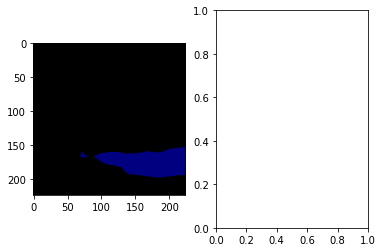

In [9]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(decode_segmap(progress.predictions[2]))
axs[1].imshow(decode_segmap(labels[2]))

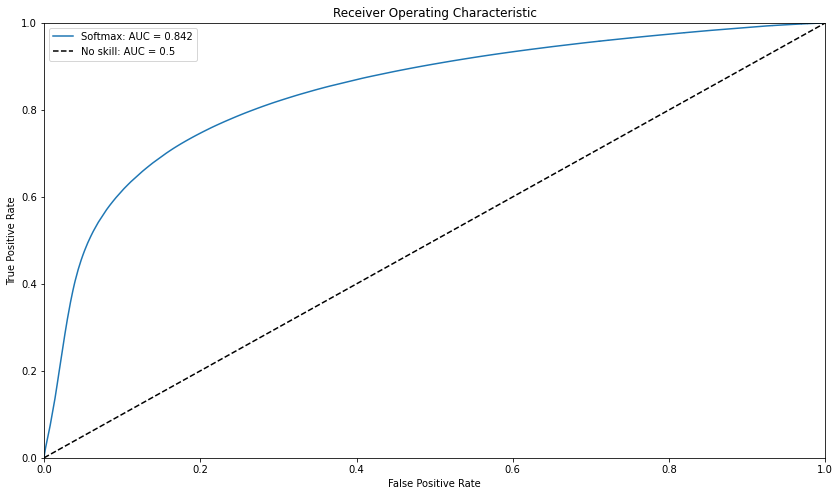

In [12]:
curves = []

correct = progress.predictions.ravel() == progress.labels.ravel()
fpr, tpr, _ = metrics.roc_curve(correct, progress.max_probs)
roc_auc = metrics.auc(fpr, tpr)

prec, recall, _ = metrics.precision_recall_curve(correct, progress.max_probs)
aupr = metrics.auc(recall, prec)
curves.append({
    "fpr": fpr,
    "tpr": tpr,
    "auroc": roc_auc,
    "prec": prec,
    "recall": recall,
    "aupr": aupr,
    "label": "Softmax"
})

# correct = progress.dropout_predictions == progress.labels
# dropout_max_probs = progress.dropout_outputs.max(axis=-1)
# fpr, tpr, _ = metrics.roc_curve(correct, dropout_max_probs)
# roc_auc = metrics.auc(fpr, tpr)

# prec, recall, _ = metrics.precision_recall_curve(correct, dropout_max_probs)
# aupr = metrics.auc(recall, prec)

# curves.append({
#     "fpr": fpr,
#     "tpr": tpr,
#     "auroc": roc_auc,
#     "prec": prec,
#     "recall": recall,
#     "aupr": aupr,
#     "label": "MC Dropout"
# })


plt.figure(figsize=(14, 8))
plt.title('Receiver Operating Characteristic')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"],
             label=f"{curve['label']}: AUC = {curve['auroc']:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

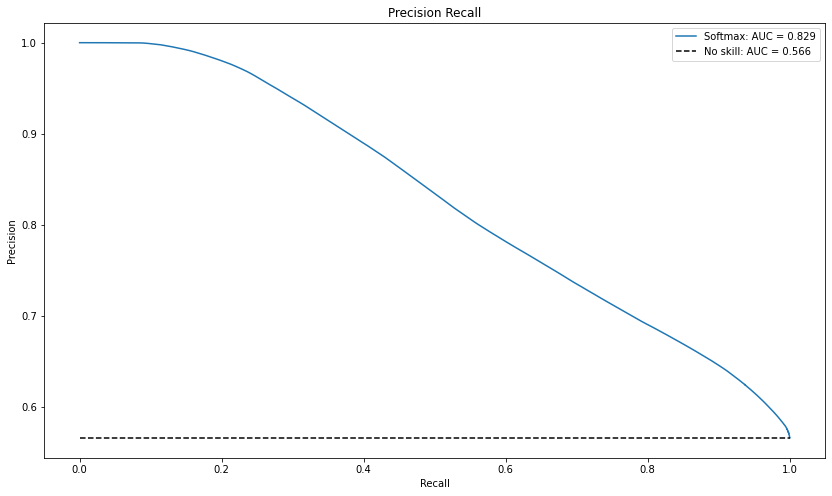

In [10]:
no_skill = correct.sum() / len(correct)
plt.figure(figsize=(14, 8))
plt.title('Precision Recall')
for curve in curves:
    plt.plot(curve["recall"], curve["prec"],
             label=f"{curve['label']}: AUC = {curve['aupr']:.3f}")
# axis labels
plt.plot([0, 1], [no_skill, no_skill], color="k",
         linestyle='--', label=f'No skill: AUC = {no_skill:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()